# SF Crime Analysis: Forecasting

### Data-x (IEOR 135)


In [1]:
# Load required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 
from collections import Counter
%matplotlib inline

C:\Users\PC\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read in data
df1 = pd.read_csv('Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')

In [3]:
# Format date columns
df1['Date'] = pd.to_datetime(df1['Date'])
df1['Year-Month'] = df1['Date'].map(lambda x: '{year}-{month}'.format(year=x.year,
                                                              month=x.month,
                                                            day=x.day))
df1['Year'] = df1['Date'].dt.year.astype(int)
df1['Week_Number'] = df1['Date'].dt.week
df1['Month_Number'] = df1['Date'].dt.month

## Wordcloud of Top Crime

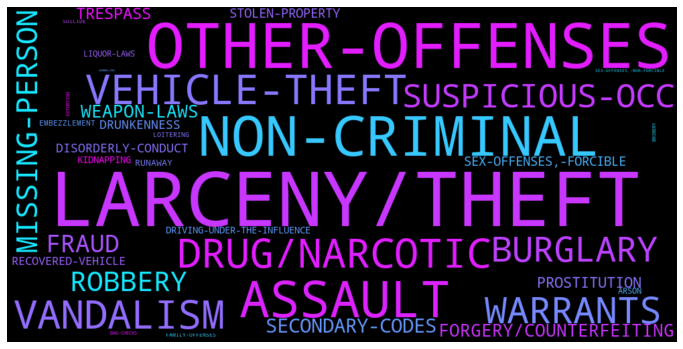

In [4]:
dic_freq = df1['Category'].str.replace(" ","-").str.split(expand=True).stack().value_counts().to_dict()
plt.figure(figsize = (12,10))
wordcloud = WordCloud(colormap="cool", background_color='black',width=1000, height=500).generate_from_frequencies(dic_freq)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## Top 10 Crimes in SF

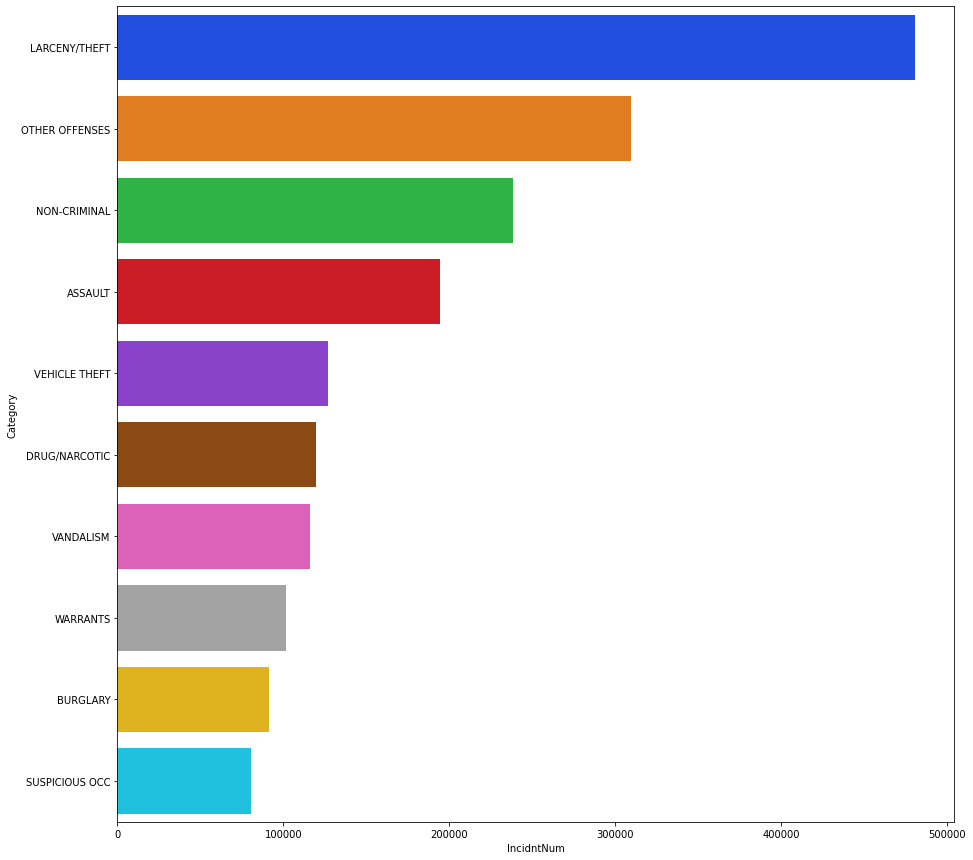

In [5]:
plt.rcParams['figure.figsize'] = (15, 15)
totalCrimes = df1.groupby('Category', as_index = False).count().sort_values(by = 'IncidntNum', ascending = False)

ax = sns.barplot(x="IncidntNum", y="Category", data=totalCrimes.head(10),palette="bright")

In [6]:
top10Crimes = list(totalCrimes.iloc[0:10,:2]['Category'])
print("Top 10 Crimes from 2003-2018 are: ")
[print("     " + str(c)) for c in top10Crimes];

Top 10 Crimes from 2003-2018 are: 
     LARCENY/THEFT
     OTHER OFFENSES
     NON-CRIMINAL
     ASSAULT
     VEHICLE THEFT
     DRUG/NARCOTIC
     VANDALISM
     WARRANTS
     BURGLARY
     SUSPICIOUS OCC


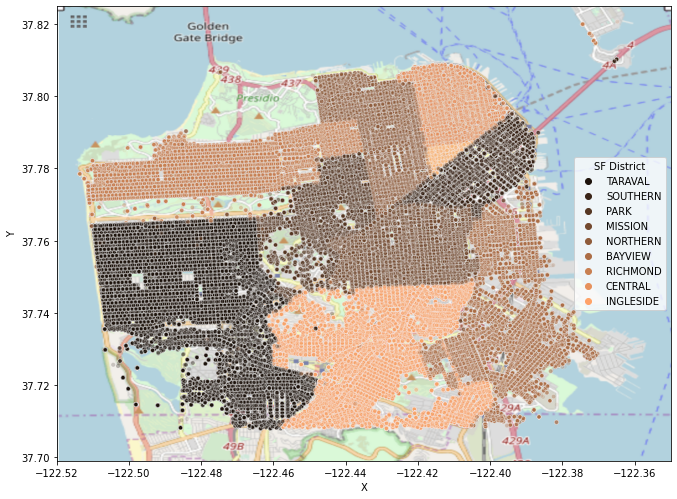

In [7]:
map_bound = ((-122.5200, -122.3500, 37.699, 37.8249))
basemap = plt.imread('sf1.png')
fig, ax = plt.subplots(figsize = (11,11))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])
plt.xlabel("Longitude")
plt.ylabel("Lattitude")
ax.imshow(basemap, zorder=0, extent = map_bound, aspect= 'equal');
sns.scatterplot(x='X', y='Y', data=df1[df1['Y']<40], hue='PdDistrict',
          palette='copper', size=.01, alpha=0.1, ax=ax)
ax.get_legend().remove()
ax.legend(ax.get_legend_handles_labels()[0][1:10], 
          ax.get_legend_handles_labels()[1][1:10], title='SF District')

Text(69.0, 0.5, '')

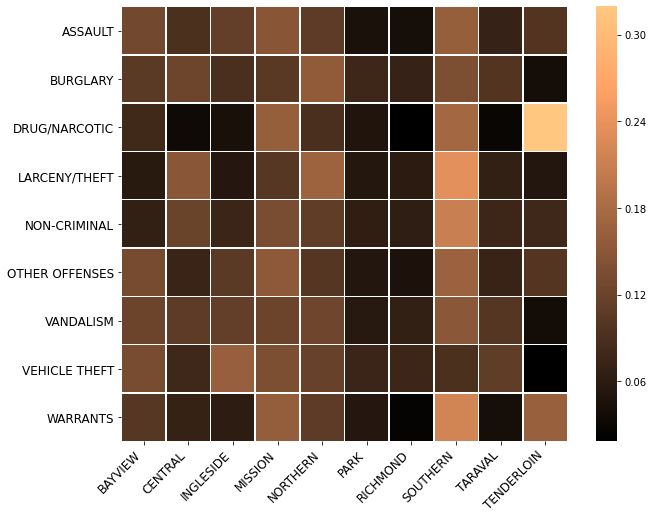

In [8]:
top_cat = df1['Category'].value_counts()[0:9].sort_values().index
top_commons = df1[df1['Category'].apply(lambda x: x in top_cat)]

cat_per_district = pd.crosstab(top_commons['Category'], top_commons['PdDistrict']) 
cat_per_district = cat_per_district.div(cat_per_district.sum(axis=1), axis=0)

fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(cat_per_district,
                 cmap="copper", linewidths=.5)
plt.xticks(fontsize=12,rotation=45,ha='right')
plt.yticks(fontsize=12)
plt.xlabel("")
plt.ylabel("")

## Yearly Crime Patterns

In [9]:
crimebefore2017 = df1[df1['Year'] <= 2017]

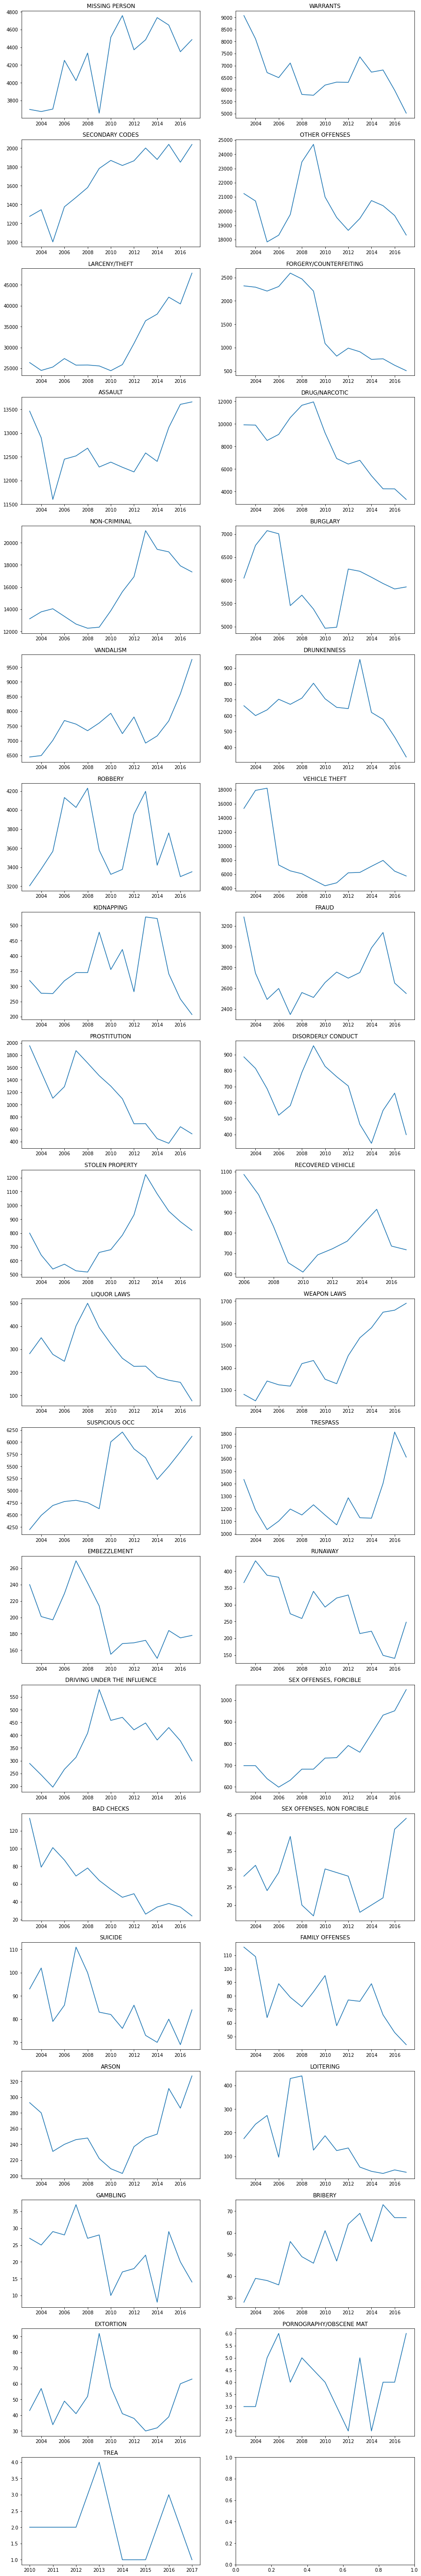

In [10]:
plt.rcParams['figure.figsize'] = (15, 5*20)
numCrimesType = 20 #df1.Category.unique().size
crimesType = list(df1.Category.unique())

f, ax = plt.subplots(nrows = 20, ncols = 2)

crime_iter = iter(crimesType)

for i in range(20):
    for j in range(2):
        
        if (i == 19) & (j == 1):
            break
        crime = next(crime_iter)
        oneCrime = crimebefore2017[crimebefore2017['Category'] == crime]
        grouped = oneCrime[['Year','Category']].groupby('Year').count()
        grouped.rename(columns = {"Category": "Count"}, inplace = True)
        ax[i,j].plot(grouped.index,grouped['Count']);
        ax[i,j].set_title(crime)
    

# Preprocessing Data for Forecasting

Analysis ideas and some code from
https://www.machinelearningplus.com/time-series/time-series-analysis-python/

## Box Plots of Number of Crimes per Month

In [11]:
# Splice relevant columns
dfBoxPlots = df1[['IncidntNum','Category','Year','Week_Number', "Month_Number"]]

# Select ASSAULT crimes only
dfBoxPlots = dfBoxPlots[dfBoxPlots['Category'] == 'ASSAULT']

# Drop records from 2018 since data from only part of the year is available
dfBoxPlots = dfBoxPlots[dfBoxPlots['Year'] < 2018]

In [12]:
# Count number of crimes per month
monthGrouped = dfBoxPlots.groupby(['Year', 'Month_Number'], as_index = False).count()
monthGrouped.rename(columns = {"IncidntNum": "Number of Incidents per Month"}, inplace = True)
monthGrouped

,Year,Month_Number,Number of Incidents per Month,Category,Week_Number
0,2003,1,1174,1174,1174
1,2003,2,1050,1050,1050
2,2003,3,1231,1231,1231
3,2003,4,1016,1016,1016
4,2003,5,1117,1117,1117
...,...,...,...,...,...
175,2017,8,1293,1293,1293
176,2017,9,1188,1188,1188
177,2017,10,1183,1183,1183
178,2017,11,1089,1089,1089


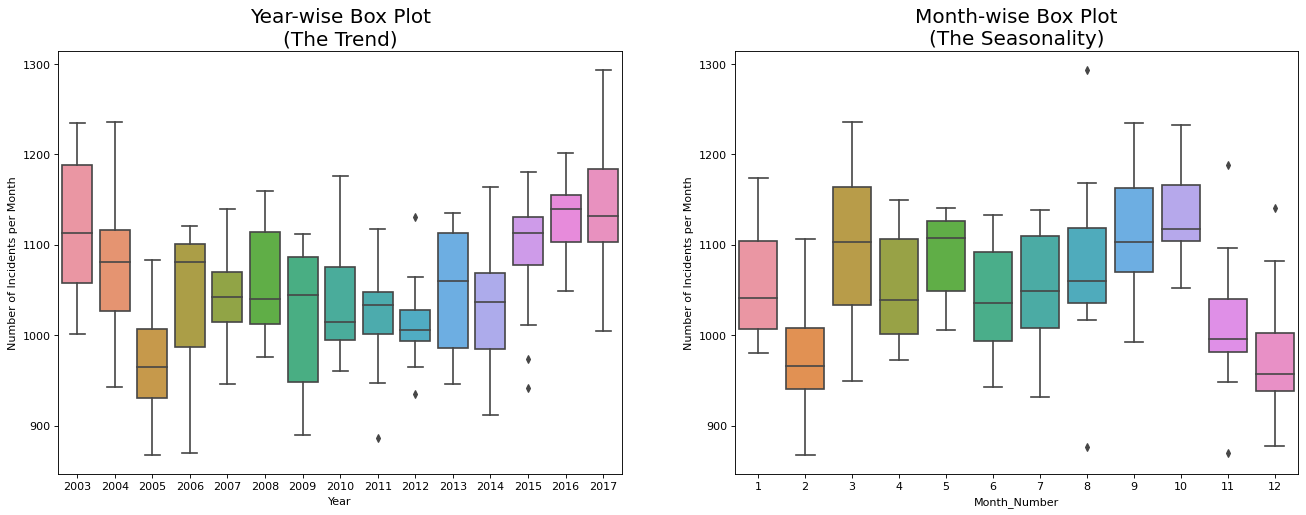

In [13]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='Number of Incidents per Month', data=monthGrouped, ax=axes[0])
sns.boxplot(x='Month_Number', y='Number of Incidents per Month', data=monthGrouped, ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Decompose Time Series into Components

In a **multiplicative decomposition**, the trend, seasonality, and residual components can be mutliplied to get the original observations.

In an **additive decomposition**, they are added together to get the orignal observation.

###  By Week

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
# Splice relevant columns
dfDecompose = df1[['IncidntNum','Category','Year','Week_Number', "Month_Number", 'Date']]

# Select ASSAULT crimes only
dfDecompose = dfDecompose[dfDecompose['Category'] == 'ASSAULT']

# Drop records from 2018 since data from only part of the year is available
dfDecompose = dfDecompose[(dfDecompose['Year'] < 2018)]

# Group by week
weekGrouped = dfDecompose.resample('W', on='Date')[['IncidntNum']].count() #.reset_index().sort_values(by='Date')
weekGrouped.rename(columns = {'IncidntNum': "Incidents/Week"}, inplace = True)

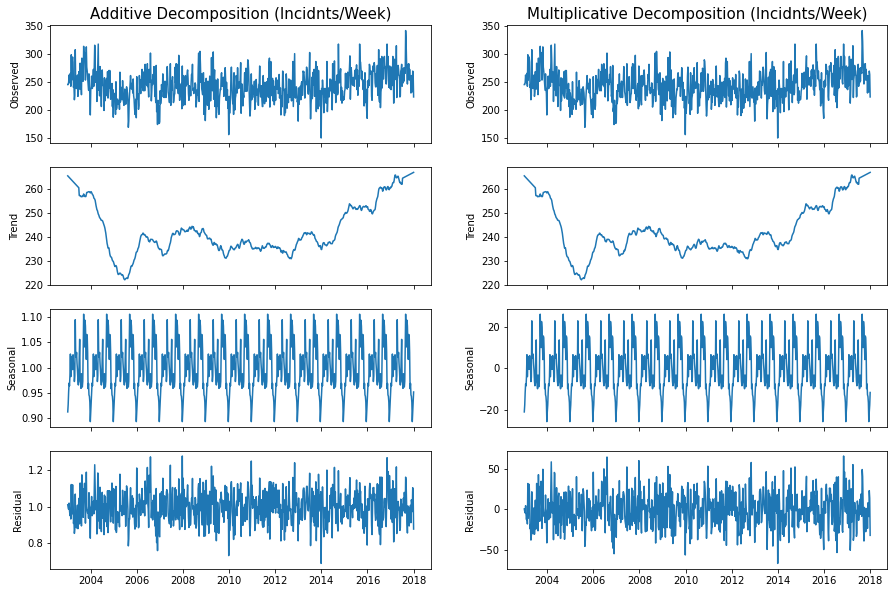

In [16]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(weekGrouped['Incidents/Week'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(weekGrouped['Incidents/Week'], model='additive', extrapolate_trend='freq')

# Create plot and set size
plt.rcParams.update({'figure.figsize': (15,10)})
f, ax = plt.subplots(nrows = 4, ncols = 2, sharex = True)

# Loop through the types of models and their index which is the column
for col, model in enumerate([result_mul, result_add]):
   
    ax[0, col].plot(model.observed)
    ax[0, col].set_ylabel('Observed')

    ax[1, col].plot(model.trend)
    ax[1, col].set_ylabel('Trend')
    
    ax[2, col].plot(model.seasonal)
    ax[2, col].set_ylabel('Seasonal')
    
    ax[3, col].plot(model.resid)
    ax[3, col].set_ylabel('Residual')

ax[0, 0].set_title("Additive Decomposition (Incidnts/Week)", fontdict = {'fontsize': 15})
ax[0, 1].set_title("Multiplicative Decomposition (Incidnts/Week)",  fontdict = {'fontsize': 15})
plt.show()


### By Month

In [17]:
# Splice relevant columns
dfDecompose = df1[['IncidntNum','Category','Year','Week_Number', "Month_Number", 'Date']]

# Select ASSAULT crimes only
dfDecompose = dfDecompose[dfDecompose['Category'] == 'ASSAULT']

# Drop records from 2018 since data from only part of the year is available
dfDecompose = dfDecompose[(dfDecompose['Year'] < 2018)]

# Group by month
monthGrouped = dfDecompose.resample('M', on='Date')[['IncidntNum']].count() #.reset_index().sort_values(by='Date')
monthGrouped.rename(columns = {'IncidntNum': "Incidents/Month"}, inplace = True)

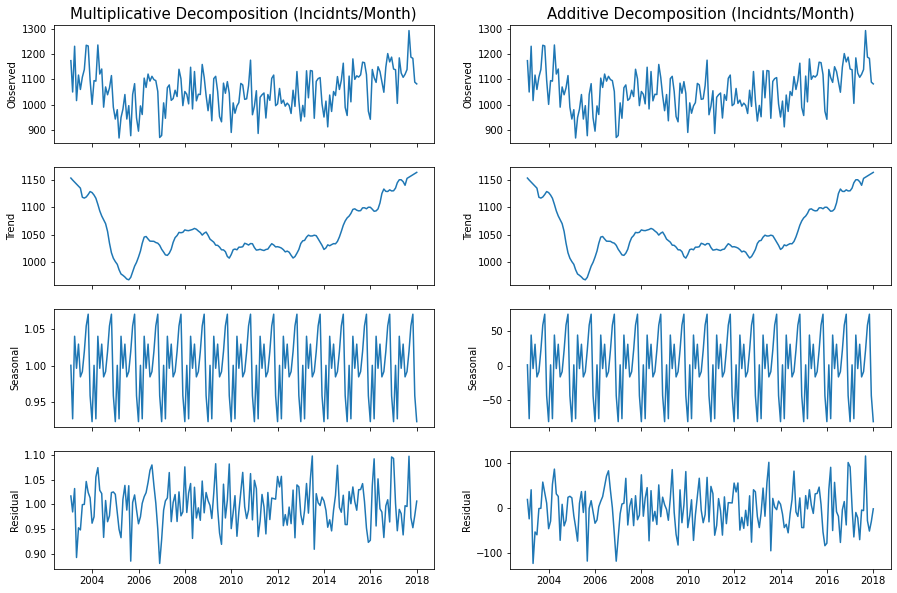

In [18]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(monthGrouped['Incidents/Month'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(monthGrouped['Incidents/Month'], model='additive', extrapolate_trend='freq')

# Create plot and set size
plt.rcParams.update({'figure.figsize': (15,10)})
f, ax = plt.subplots(nrows = 4, ncols = 2, sharex = True)

# Loop through the types of models and their index which is the column
for col, model in enumerate([result_mul, result_add]):
   
    ax[0, col].plot(model.observed)
    ax[0, col].set_ylabel('Observed')

    ax[1, col].plot(model.trend)
    ax[1, col].set_ylabel('Trend')
    
    ax[2, col].plot(model.seasonal)
    ax[2, col].set_ylabel('Seasonal')
    
    ax[3, col].plot(model.resid)
    ax[3, col].set_ylabel('Residual')

ax[0, 0].set_title("Multiplicative Decomposition (Incidnts/Month)",  fontdict = {'fontsize': 15})
ax[0, 1].set_title("Additive Decomposition (Incidnts/Month)", fontdict = {'fontsize': 15})
plt.show()

In [19]:
# Combine seasonality, trend, residual to make an new dataframe
df_multDecompose = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_multDecompose.columns = ['seas', 'trend', 'resid', 'actual_values']
df_multDecompose.head()

df_addDecompose = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_addDecompose.columns = ['seas', 'trend', 'resid', 'actual_values']
df_addDecompose.head()

,seas,trend,resid,actual_values
Date,,,,
2003-01-31,1.014341,1153.616696,19.368964,1174
2003-02-28,-76.450442,1149.921766,-23.471324,1050
2003-03-31,43.898665,1146.226836,40.874500,1231
2003-04-30,-4.321673,1142.531906,-122.210232,1016
2003-05-31,30.682989,1138.836976,-52.519964,1117


## Should a seasonal or standard ARIMA model be used?

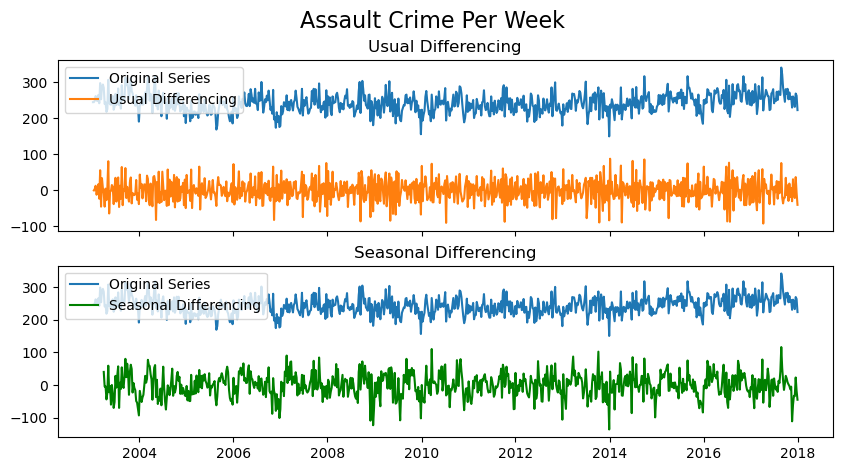

In [20]:
# Import
data = weekGrouped

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Assault Crime Per Week', fontsize=16)
plt.show()

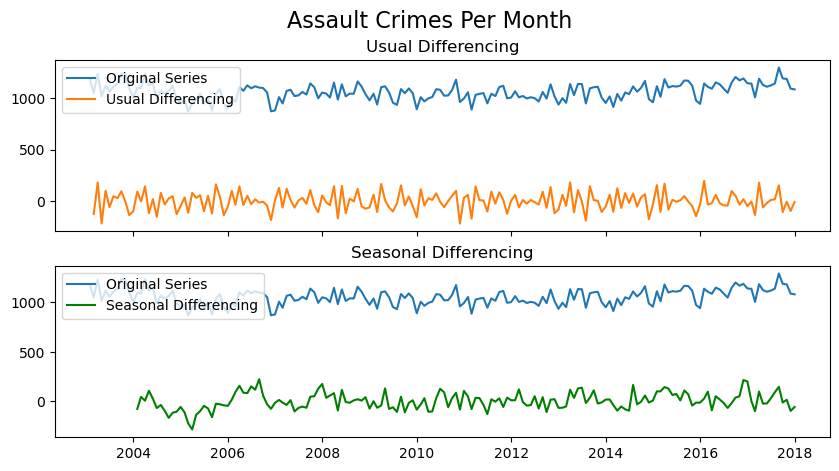

In [21]:
# Import
data = monthGrouped

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Assault Crimes Per Month', fontsize=16)
plt.show()

Seasonality differencing does not seem to smooth out the time series. Therefore it seems that assault crimes do not exhibit very strong seasonality and a nonseasonal model may be sufficient.

# Forecasting Models

## Error Metrics to Compare Models

The models will be compared with the following metrics. Models are tested on data from 2003  - 2016 and then tested on 2017 data.

**Mean Absolute Error (MAE)** <br>
$Error =  mean( |y_{actual} - y_{predict}|)$

**Root Mean Squared Error** <br>
$Error =  \sqrt{mean((y_{actual} - y_{predict})^{2})}$

**Mean Abosolute Percentage Error (MAPE)** <br>
$Error =  mean(|\frac{y_{actual} - y_{predict}}{y_{actual}}|)$

In [22]:
#Functions to quantify forecast error
# Referenced from https://otexts.com/fpp2/accuracy.html

# Mean Absolute Error
def mae(y_predict, y_actual):
    return round(np.mean(abs(y_predict - y_actual)),2)

# Mean Root Squared Error
def rmse(y_predict, y_actual):
    return round(np.sqrt(np.mean((y_predict - y_actual)**2)),2)

# Mean Absolute Percentage Error
def MAPE(y_predict, y_actual):
    return round(np.mean(abs((y_predict - y_actual)/y_actual)) * 100,2)

## Baseline Model

Our baseline model always predicts the average crimes per month

In [23]:
baselineData = monthGrouped.copy()

# The predicated value is the average of the training set. 
baselineDataTrain = baselineData[baselineData.index.year < 2017]
baselineDataTest = baselineData[baselineData.index.year == 2017]

# Make a copy of the test data to get the date index
predictedValues = baselineDataTest.copy()

# Create a column with the mean of the training set as the forecast
predictedValues['Forecast'] = baselineDataTrain['Incidents/Month'].mean()

predictedValues = predictedValues['Forecast']
actualValues = baselineDataTest['Incidents/Month']

print("OUT OF SAMPLE ERROR:") 
print("Mean Absolute Error (MSE): ", mae(predictedValues, actualValues))
print("Root Mean Squared Error (RSME): ", rmse(predictedValues, actualValues))
print("Mean Absolute Percentage Error (MAPE): ", MAPE(predictedValues, actualValues), '%')

OUT OF SAMPLE ERROR:
Mean Absolute Error (MSE):  95.22
Root Mean Squared Error (RSME):  110.92
Mean Absolute Percentage Error (MAPE):  8.13 %


## SARIMA Model

Analysis steps and code from https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

Seasonal Auto Regressive Integrated Moving Average (ARIMA) models are linear regression models built upon lags (different between current and previous obsevation) and forecast errors.

ARIMA model parameters:
- p is the order of the AR term (the number of lags to be used as predictors)
- q is the order of the MA term (then number of lagged forecast errors to be used as predictors)
- d is the number of differencing required to make the time series stationary


In [24]:
# Data we are using to forecast
monthGrouped

,Incidents/Month
Date,
2003-01-31,1174
2003-02-28,1050
2003-03-31,1231
2003-04-30,1016
2003-05-31,1117
...,...
2017-08-31,1293
2017-09-30,1188
2017-10-31,1183


Code adapted from https://github.com/liyenhsu/SF-Crime-Analysis/blob/master/sf_crime_analysis.ipynb

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [26]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [27]:
y_past = monthGrouped[monthGrouped.index.year < 2017]

In [28]:
warnings.filterwarnings("ignore")
aic_min = float("inf")
param = (0,0,0,0,0,0)
best_model = None

for x1 in pdq:
    for x2 in seasonal_pdq:
        try:
            mod = SARIMAX(y_past,
                          order = x1,
                          seasonal_order = x2,
                          enforce_stationarity = False,
                          enforce_invertibility = False)
            results = mod.fit()
            #print ("(p,d,q,P,D,Q,S) = {}: AIC = {}".format(x1 + x2, results.aic))
            if results.aic < aic_min:
                aic_min = results.aic
                param = x1 + x2
                best_model = mod
        except:
            continue

In [29]:
print ("Best (p,d,q,P,D,Q,S) =", param)

Best (p,d,q,P,D,Q,S) = (0, 1, 1, 0, 1, 1, 12)


In [30]:
results = best_model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.7060,0.053,-13.306,0.000,-0.810,-0.602
ma.S.L12,-1.0000,0.138,-7.257,0.000,-1.270,-0.730
sigma2,2804.1812,4.91e-05,5.71e+07,0.000,2804.181,2804.181


In [31]:
y = monthGrouped

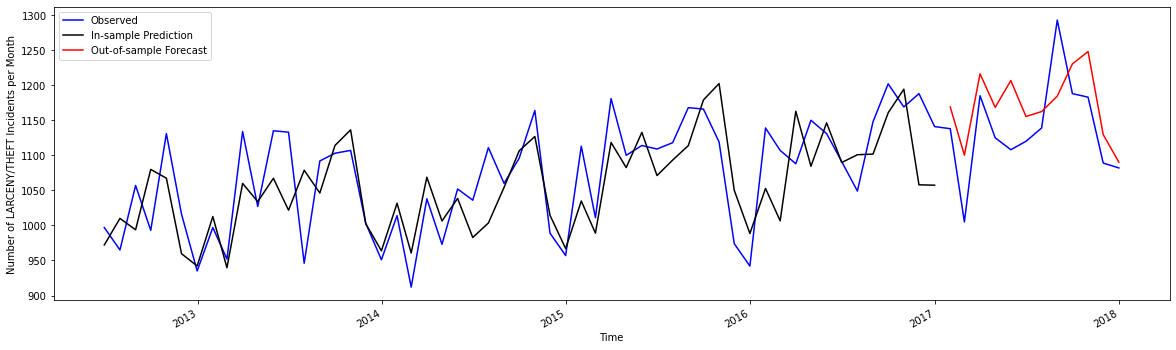

In [32]:
# neglect the beginning of the time series, where the model hasn't converged
pred = results.get_prediction(start = y_past['2012-06':].index[0],  dynamic=False)
pred_ci = pred.conf_int() # 95% confidence interval 

forecast = results.get_forecast(steps=12) # forecast for the next 12 months
forecast_ci = forecast.conf_int() # 95% confidence interval 

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y['2012-06':].index, y['2012-06':], label='Observed', color='b')

pred.predicted_mean.plot(ax=ax, label='In-sample Prediction', color='k')
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)

forecast.predicted_mean.plot(ax=ax, label='Out-of-sample Forecast', color='r')
#ax.fill_between(forecast_ci.index,
#                forecast_ci.iloc[:, 0],
#                forecast_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Time')
ax.set_ylabel('Number of LARCENY/THEFT Incidents per Month')
plt.legend()
plt.show()

In [33]:
predictedValues = forecast.predicted_mean;
actualValues = monthGrouped[monthGrouped.index.year == 2017]['Incidents/Month']

print("OUT OF SAMPLE ERROR:") 
print("Mean Absolute Error (MSE): ", mae(predictedValues, actualValues))
print("Root Mean Squared Error (RSME): ", rmse(predictedValues, actualValues))
print("Mean Absolute Percentage Error (MAPE): ", MAPE(predictedValues, actualValues), '%')


OUT OF SAMPLE ERROR:
Mean Absolute Error (MSE):  51.96
Root Mean Squared Error (RSME):  60.53
Mean Absolute Percentage Error (MAPE):  4.57 %


## Triple Exponential Smoothing Model

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# prepare data

data = y_past

# create class
model = ExponentialSmoothing(data, 
                             trend = 'add', 
                             seasonal = 'add',
                             seasonal_periods = 12)

# fit model
model_fit = model.fit()

# make prediction
inSamplePrediction = model_fit.predict(start = '2012-06', end  = '2017-1')
forecast = model_fit.forecast(12)

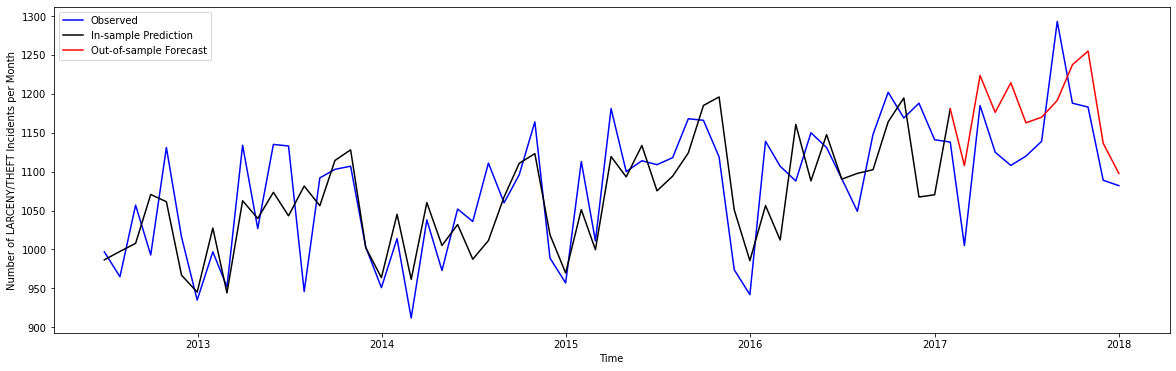

In [35]:
# neglect the beginning of the time series, where the model hasn't converged

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y['2012-06':].index, y['2012-06':], label='Observed', color='b')

ax.plot(inSamplePrediction, label='In-sample Prediction', color='k')
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.plot(forecast, label='Out-of-sample Forecast', color='r')
#ax.fill_between(forecast_ci.index,
#                forecast_ci.iloc[:, 0],
#                forecast_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Time')
ax.set_ylabel('Number of LARCENY/THEFT Incidents per Month')
plt.legend()
plt.show()

In [36]:
predictedValues = forecast
actualValues = monthGrouped[monthGrouped.index.year == 2017]['Incidents/Month']

print("OUT OF SAMPLE ERROR:") 
print("Mean Absolute Error: ", mae(predictedValues, actualValues))
print("Root Mean Squared Error: ", rmse(predictedValues, actualValues))
print("Mean Absolute Percentage Error (MAPE): ", MAPE(predictedValues, actualValues), '%')

OUT OF SAMPLE ERROR:
Mean Absolute Error:  58.44
Root Mean Squared Error:  65.19
Mean Absolute Percentage Error (MAPE):  5.15 %


## Random Forest Model

Analysis ideas from http://mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/

Builds Random Forest model off of lags (current month minus previous month) and number of crimes in the previous month. 

In [37]:
# sklearn.model_selection
from sklearn.ensemble import RandomForestRegressor

In [38]:
def add_lag_prevObsers(X_rf):
    """ Creates a copy of the input dataframe and adds columns for previous crime count and lags
    """ 
    X = X_rf.copy()
    
    # Add featurs which says the current month that is being predicted
    X['MonthNum'] =  X_rf.index.month
    
    # Add number of crimes observed in the previous month
    X['Last_Month_Count'] =  X['Incidents/Month'].shift(1)
    X['Last-1_Month_Count'] =  X['Incidents/Month'].shift(2)
    X['Last-2_Month_Count'] =  X['Incidents/Month'].shift(3)
    #X['Last-11_Month_Count'] =  X['Incidents/Month'].shift(12)
    
    # Add lag columns
    for i,col in enumerate(['Last-1_Month_Count','Last-2_Month_Count']):
        X['Lag_' + str(i+1) + "_Month"] = X['Last_Month_Count'] - X[col]

    return X

In [39]:
# Add lags and umber of crimes in past months to a copy of months Grouped
X_rfFeatures = add_lag_prevObsers(monthGrouped)

# Filter to only 2016 to build model
dateToTrainUpTo = 2016
X_rfFeatures = X_rfFeatures[(X_rfFeatures.index.year <= dateToTrainUpTo)]

In [40]:
# Clean data before training model

# Remove NaN's
X_rfFeatures.dropna(inplace = True)

#Split into X and Y training data
X_train = X_rfFeatures.drop(columns = ['Incidents/Month'])
y_train = X_rfFeatures['Incidents/Month']

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (165, 6)
Shape of y_train:  (165,)


In [41]:
# Initialize and create Random Forest Model
RF = RandomForestRegressor()
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [42]:
# In order to forecast, a month I will need the number of crimes observed in previous months and 
# the lag between the last month and other previous months. These functions input a DataFrame called
# y_last that has the date as the index and the return then number of lags or observations i months ago

def get_Last_Minus_i_Month_Count(y_past, i):
    return int(y_past.iloc[-(i+1),:])

def get_Lag_i_Month_Count(y_past, i):
    return get_Last_Minus_i_Month_Count(y_past, 0) - get_Last_Minus_i_Month_Count(y_past, i)
    

In [43]:
def getModelInputRow(y_input, date):
    """ In order to forecast, we need the lags and number of crimes observed in previous months. This function inputs a DataFrame
        of with index as the dates and a column with the observations and returns a row vector with each entry corresponding to 
        the previous months number of observations and lags.
    """
    # Initialize row vector that will be returned
    x_test = []
    
    # Add month
    x_test.append(date.month)
    
    # Add previous month entries
    for i in [0,1,2]:
        x_test.append(get_Last_Minus_i_Month_Count(y_input, i))
    
    # Add lag entries
    for i in [1,2]:
        x_test.append(get_Lag_i_Month_Count(y_input, i))
        
    return [x_test]

### Out of Sample Testing

Calculating the OOS error is a bit difficult because to forecast one month requires the number of crime in the months before it. We can forecast one month into the future, however, if we want to forecast 2 months into the future we will need to use the forecast for the first month as an input into the 2nd months forecast.

We have used this process to forecast 12 months out. Because previous forecasts are used to calculate the next moth, the error builds with each consecutive forecast.


In [44]:
# Create a copy of the number of observed crimes to append to later.
y_hist = X_rfFeatures[['Incidents/Month']]

# Get month indexes in 2017 to predict on
dates2017pred = monthGrouped[monthGrouped.index.year > dateToTrainUpTo]

# Initialize an empty DataFrame where forecasts will be placed in
rfForecast_df = pd.DataFrame()

# Loop through the date indexes and forecast each date. Add that date to the dataframe and use that forecasted quantity to
# predict the demand for the next month until the whole year has forecasts
for date in dates2017pred.index:
    nextRow = getModelInputRow(y_hist, date)
    y_pred = RF.predict(nextRow)
    forecastRow = pd.DataFrame(data = [y_pred], columns = ['Incidents/Month'], index = [date])
    y_hist = y_hist.append(forecastRow)
    rfForecast_df = rfForecast_df.append(forecastRow)

In [45]:
# Make forecasts into a series so it ca nbe graphed
rfForecast = rfForecast_df['Incidents/Month']

# Slice actual crime counts or y_test data
y_test = monthGrouped[monthGrouped.index.year > dateToTrainUpTo]['Incidents/Month']

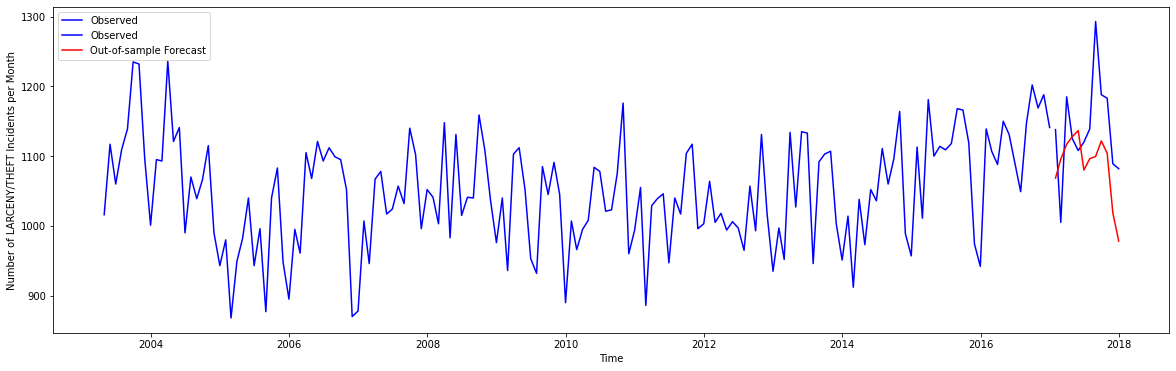

In [46]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y_train.index, y_train, label='Observed', color='b')
ax.plot(y_test.index, y_test, label='Observed', color='b')

#ax.plot(y_train.index, ypred, label='In-sample Prediction', color='k')
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.plot(rfForecast.index, rfForecast, label='Out-of-sample Forecast', color='r')
#ax.fill_between(forecast_ci.index,
#                forecast_ci.iloc[:, 0],
#                forecast_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Time')
ax.set_ylabel('Number of LARCENY/THEFT Incidents per Month')
plt.legend()
plt.show()

In [47]:
print("OUT OF SAMPLE ERROR:") 
print("Mean Absolute Error: ", mae(rfForecast, y_test))
print("Root Mean Squared Error: ", rmse(rfForecast, y_test))
print("Mean Absolute Percentage Error (MAPE): ", MAPE(rfForecast, y_test), '%')


OUT OF SAMPLE ERROR:
Mean Absolute Error:  71.28
Root Mean Squared Error:  84.52
Mean Absolute Percentage Error (MAPE):  6.19 %


## Adaboost Regressor

In [48]:
from sklearn.ensemble import AdaBoostRegressor

# Initialize and Adaboost Regressor Model
adaboostRegr = RandomForestRegressor()

# Train on X_train and y_train created in the Random Forest section
adaboostRegr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [49]:
def forecastGraph_PrintError(model):
    """This function inputs a regression model (random forest, adaboost, etc) object that has already has .fit called and 
       and returns a graph of the forecast and prints the error.
    """
    # Create a copy of the number of observed crimes to append to later.
    y_hist = X_rfFeatures[['Incidents/Month']]

    # Get month indexes in 2017 to predict on
    dates2017pred = monthGrouped[monthGrouped.index.year > dateToTrainUpTo]

    # Initialize an empty DataFrame where forecasts will be placed in
    rfForecast_df = pd.DataFrame()

    # Loop through the date indexes and forecast each date. Add that date to the dataframe and use that forecasted quantity to
    # predict the demand for the next month until the whole year has forecasts
    for date in dates2017pred.index:
        nextRow = getModelInputRow(y_hist, date)
        y_pred = model.predict(nextRow)
        forecastRow = pd.DataFrame(data = [y_pred], columns = ['Incidents/Month'], index = [date])
        y_hist = y_hist.append(forecastRow)
        rfForecast_df = rfForecast_df.append(forecastRow)

    # Make forecasts into a series so it ca nbe graphed
    rfForecast = rfForecast_df['Incidents/Month']

    # Slice actual crime counts or y_test data
    y_test = monthGrouped[monthGrouped.index.year > dateToTrainUpTo]['Incidents/Month']

    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Combine training and test index values into one series to plot
    observed_index = y_train.index.append(y_test.index)
    
    # Combine training and test values into one series to plot
    observed_values =  y_train.append(y_test)
    
    #Plot Observed Data and Forecasts
    ax.plot(observed_index, observed_values, label='Observed', color='b')
    ax.plot(rfForecast.index, rfForecast, label='Out-of-sample Forecast', color='r')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of LARCENY/THEFT Incidents per Month')
    plt.legend()
    plt.show()

    print("OUT OF SAMPLE ERROR:") 
    print("Mean Absolute Error: ", mae(rfForecast, y_test))
    print("Root Mean Squared Error: ", rmse(rfForecast, y_test))
    print("Mean Absolute Percentage Error (MAPE): ", MAPE(rfForecast, y_test), '%')


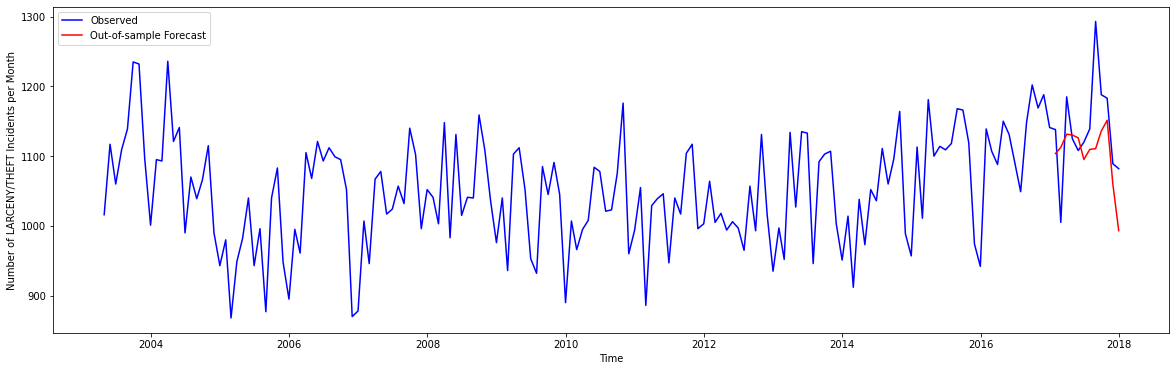

OUT OF SAMPLE ERROR:
Mean Absolute Error:  54.75
Root Mean Squared Error:  72.52
Mean Absolute Percentage Error (MAPE):  4.76 %


In [50]:
forecastGraph_PrintError(adaboostRegr)

## Gradient Boosting Regressor

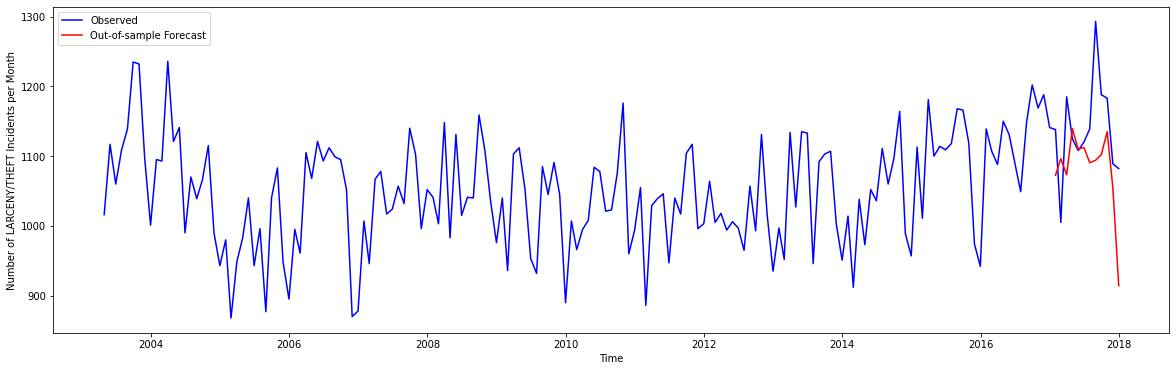

OUT OF SAMPLE ERROR:
Mean Absolute Error:  72.96
Root Mean Squared Error:  94.09
Mean Absolute Percentage Error (MAPE):  6.33 %


In [51]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and Adaboost Regressor Model
gradBoostRegr = GradientBoostingRegressor()

# Train on X_train and y_train created in the Random Forest section
gradBoostRegr.fit(X_train, y_train)

forecastGraph_PrintError(gradBoostRegr)